# Stats 2 Project 2
<i>Kito Patterson and Hayley Horn

## Load the Data

In [37]:
#load packages
import pandas as pd
import numpy as np 
import warnings
import statsmodels.api as sm
import pylab as pl

warnings.filterwarnings('ignore')

In [38]:
# Data import
df = pd.read_csv("hmeq.csv") 

## Exploratory Data Analysis

In [39]:
# Get a quick summary of table structure
print("Number of Rows, Number of Columns:", df.shape)

Number of Rows, Number of Columns: (5960, 13)


In [40]:
# View the first 5 rows
df.head() 

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


Row 3 in the top 5 rows contains mostly NaN values, and would not be useful for analysis.

In [41]:
#review data set non-nulls and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
BAD        5960 non-null int64
LOAN       5960 non-null int64
MORTDUE    5442 non-null float64
VALUE      5848 non-null float64
REASON     5708 non-null object
JOB        5681 non-null object
YOJ        5445 non-null float64
DEROG      5252 non-null float64
DELINQ     5380 non-null float64
CLAGE      5652 non-null float64
NINQ       5450 non-null float64
CLNO       5738 non-null float64
DEBTINC    4693 non-null float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


This dataset seems to have some missing values that need to be addressed before EDA. Lets take a look below.

In [42]:
#review basic summary statistics
df_desc = df.describe()

# display the descriptive statistics rounded to two decimals
df_desc.round(3) 


,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000,5960.00,5442.000,5848.000,5445.000,5252.000,5380.000,5652.000,5450.000,5738.000,4693.000
mean,0.199,18607.97,73760.817,101776.049,8.922,0.255,0.449,179.766,1.186,21.296,33.780
std,0.400,11207.48,44457.609,57385.775,7.574,0.846,1.127,85.810,1.729,10.139,8.602
min,0.000,1100.00,2063.000,8000.000,0.000,0.000,0.000,0.000,0.000,0.000,0.524
25%,0.000,11100.00,46276.000,66075.500,3.000,0.000,0.000,115.117,0.000,15.000,29.140
50%,0.000,16300.00,65019.000,89235.500,7.000,0.000,0.000,173.467,1.000,20.000,34.818
75%,0.000,23300.00,91488.000,119824.250,13.000,0.000,0.000,231.562,2.000,26.000,39.003
max,1.000,89900.00,399550.000,855909.000,41.000,10.000,15.000,1168.234,17.000,71.000,203.312


Mortdue and value have the most range and variance

Now lets take a closer look at the missing values by column.

In [43]:
# Missing values sort descending
df_percent = df.isna().sum()/len(df)*100 # Percent of total 'NaN' rows by column
df_percent.sort_values(ascending=False)

DEBTINC    21.258389
DEROG      11.879195
DELINQ      9.731544
MORTDUE     8.691275
YOJ         8.640940
NINQ        8.557047
CLAGE       5.167785
JOB         4.681208
REASON      4.228188
CLNO        3.724832
VALUE       1.879195
LOAN        0.000000
BAD         0.000000
dtype: float64

'DEBTINC' (Debt to Income ratio) is missing for more than 20% of its values followed by 'DEROG' at 11%. That may be too many values to impute. We may want to impute values within groupings as a alternative. For example, 'DEBTINC' mean or median values may be significantly different for "Sales" vs "Other" job titles. We need to explore deeper to see if there is a story to uncover if we decide to impute.

Almost half of the dataset is lost if we remove all rows with at least 1 NaN value. That isn't necessarily a bad thing, but it is worth noting. Imputing variables may be an option at a later juncture. We will move forward by simply removing rows with missing values for now.

In [44]:
#Create new dataframe with NaN rows removed
df_NoNaN = df.dropna() 

# comparing NEW (df) vs OLD (df2) dataframes 
print("Old data frame length:", len(df), "\nNew data frame length:",  
       len(df_NoNaN), "\nNumber of rows with at least 1 NA value: ", 
       (len(df)-len(df_NoNaN)),"\nPercent of total rows lost to NA values:",
     (len(df)-len(df_NoNaN))/len(df))

Old data frame length: 5960 
New data frame length: 3364 
Number of rows with at least 1 NA value:  2596 
Percent of total rows lost to NA values: 0.4355704697986577


## Exploratory Data Analysis Part 2 
#KITO- DOES THIS EXCLUDE NaN records?

In [45]:
#Summary stats for Paid loans
df[df['BAD']==0].drop('BAD', axis=1).describe().style.format("{:.2f}")

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,4771.00,4359.00,4764.00,4321.00,4150.00,4263.00,4541.00,4336.00,4602.00,4290.00
mean,19028.11,74829.25,102595.92,9.15,0.13,0.25,187.00,1.03,21.32,33.25
std,11115.76,43584.99,52748.39,7.68,0.51,0.67,84.47,1.53,9.68,6.95
min,1700.00,2619.00,8000.00,0.00,0.00,0.00,0.49,0.00,0.00,0.72
25%,11700.00,47484.00,67297.75,3.00,0.00,0.00,120.22,0.00,15.00,28.91
50%,16900.00,66839.00,90659.00,7.00,0.00,0.00,180.42,1.00,20.00,34.54
75%,23500.00,93068.00,120615.50,13.00,0.00,0.00,240.16,2.00,26.00,38.74
max,89900.00,371003.00,471827.00,36.00,6.00,5.00,649.75,11.00,56.00,45.57


In [46]:
#Summary stats for Default loans
df[df['BAD']==1].drop('BAD', axis=1).describe().style.format("{:.2f}")

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,1189.00,1083.00,1084.00,1124.00,1102.00,1117.00,1111.00,1114.00,1136.00,403.00
mean,16922.12,69460.45,98172.85,8.03,0.71,1.23,150.19,1.78,21.21,39.39
std,11418.46,47588.19,74339.82,7.10,1.47,1.90,84.95,2.25,11.81,17.72
min,1100.00,2063.00,8800.00,0.00,0.00,0.00,0.00,0.00,0.00,0.52
25%,9200.00,39946.50,59368.25,2.00,0.00,0.00,96.03,0.00,13.00,32.38
50%,14900.00,60279.00,82000.00,6.00,0.00,0.00,132.87,1.00,20.00,38.08
75%,21700.00,85864.50,116000.00,12.00,1.00,2.00,193.28,3.00,28.00,43.29
max,77400.00,399550.00,855909.00,41.00,10.00,15.00,1168.23,17.00,71.00,203.31


In [47]:
# Create dataframe for numeric values only
df_numeric = df._get_numeric_data()

In [48]:
# View the first 5 rows
df_numeric.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


### Scatterplot Matrices

"VALUE" and "MORTDUE" display evidence of multicollinearity. As home values increase so does the TOTAL mortgage due which would makes sense. We may not need both variables, but we will asses that in later modeling efforts.

In [ ]:
# Import plotting packages
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="ticks")

cols_cont = ['BAD','LOAN','MORTDUE','VALUE','YOJ','DEROG','DELINQ','DEBTINC']

pp = sns.pairplot(df[cols_cont], 
                  size=1.8,
                  aspect=1.0,
                  hue='BAD')
fig = pp.fig
fig.subplots_adjust(top=0.93, wspace=0.3)
fig.suptitle('HMEQ Numeric Pairwise Plots', 
              fontsize=14, fontweight='bold')

### Heatmap

The heatmap shows 'VALUE' and 'MORTDUE' are the only variables with high mulitcollinearity.

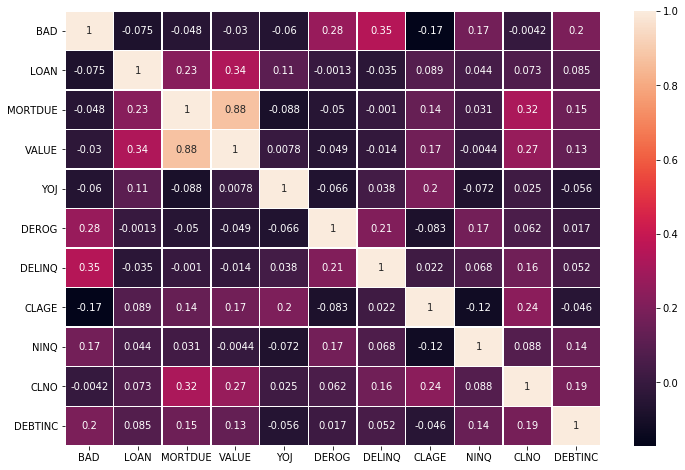

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

#this increases the plot size
plt.figure(figsize=(12,8))

#Creates a heatmap of correlated data
sns.heatmap(df.corr(), annot=True, linewidth=0.5)

### VIF

Logistic regression is not robust to multicollinearlity. Although the scatterplot matrix gives us a good visual of possible multicollinearity, VIF values gives us an additional measure to safe guard against collenearity amongst explanatory variables. As suspected, 'VALUE' and 'MORTDUE' are borderline, but they fall under the accetable threshold (VIF >5). In a attempt to reduce the amount of variables and complexities in our model, we will remove one of the two variables in support of subsequent modeling efforts.

In [51]:
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Break into left and right hand side; y and X
y, X = dmatrices(formula_like = "BAD ~ LOAN + MORTDUE + VALUE + YOJ + DEROG + DELINQ + CLAGE + NINQ + CLNO + DEBTINC", 
                 data = df_numeric, NA_action = "drop", return_type = "dataframe")

# For each Xi, calculate VIF
vif = pd.DataFrame()
vif['factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['features'] = X.columns

# Inspect VIF Factors
vif

,factor,features
0,28.745864,Intercept
1,1.221337,LOAN
2,4.522241,MORTDUE
3,4.597730,VALUE
4,1.108692,YOJ
5,1.069189,DEROG
6,1.050836,DELINQ
7,1.167511,CLAGE
8,1.074835,NINQ
9,1.226400,CLNO


We will remove the 'VALUE' variable given it is has a VIF closest to 5. This will allow us to reduce model complexity as much as possible before our model/feature selection efforts. 

In [52]:
# Drop "VALUE" from df
df.drop(['VALUE'], axis=1, inplace=True)

# Drop "VALUE" from df_NoNaN frame
df_NoNaN.drop(['VALUE'], axis=1, inplace=True)


In [53]:
# View the first 5 rows with no "VALUE" field
df.head()

,BAD,LOAN,MORTDUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


The third record does not seem to have a lot of analytical value.

In [54]:
# View the first 5 rows with the NaNs removed
df_NoNaN.head()

,BAD,LOAN,MORTDUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
5,1,1700,30548.0,HomeImp,Other,9.0,0.0,0.0,101.466002,1.0,8.0,37.113614
7,1,1800,28502.0,HomeImp,Other,11.0,0.0,0.0,88.766030,0.0,8.0,36.884894
19,0,2300,102370.0,HomeImp,Office,2.0,0.0,0.0,90.992533,0.0,13.0,31.588503
25,1,2400,34863.0,HomeImp,Mgr,12.0,0.0,0.0,70.491080,1.0,21.0,38.263601
26,0,2400,98449.0,HomeImp,Office,4.0,0.0,0.0,93.811775,0.0,13.0,29.681827


### Analyzing Data

In [55]:
# Import plotting packages
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

The response variable is unbalanced. We may need to address this behavior when modeling. 

Text(0.5, 1.0, 'Default Counts Yes/No')

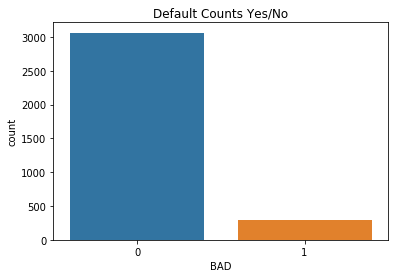

In [56]:
sns.countplot(x="BAD",data=df_NoNaN).set_title('Default Counts Yes/No')

Most borrowers are using their property equity to consolidate debt 

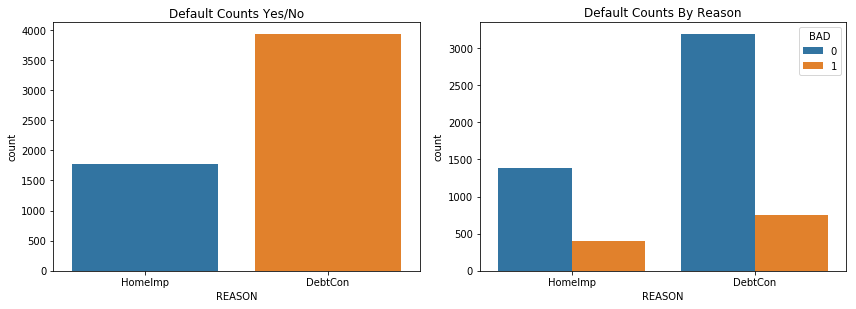

In [57]:
# How to get Percent values by attribute shown on graphs?
plt.figure(figsize=(12,8))

plt.subplot(221)
sns.countplot(x="REASON",data=df).set_title('Default Counts Yes/No')

plt.subplot(222)
sns.countplot(x="REASON", hue="BAD", data=df).set_title('Default Counts By Reason')

#plt.subplot(223)
#sns.countplot(x="JOB", hue="BAD", data=df).set_title('Default Counts By Job Type')

plt.tight_layout()

Borrowers who default tend to have slighty less years on the job than borrowers who don't default. They are likely less established with lower salaries that may signal more defaults. There also seems to be some seperation between both response populations and "CLAGE" (Age of oldest tradeline in # of months). This could indicate that less credit history can potentially lead to higher defaults. It is important to note the mean for defaults are skewed by a few outliers. We may need to investigate those observations further.

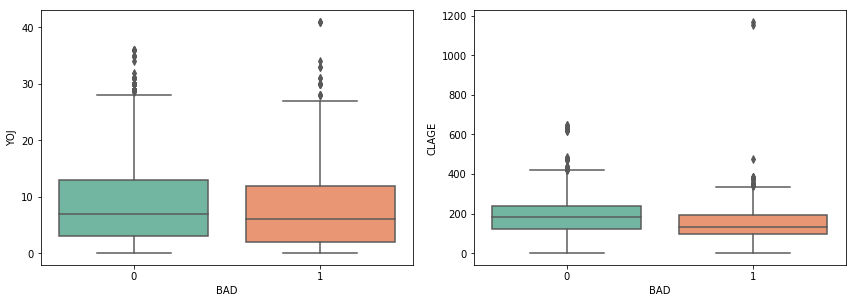

In [58]:
plt.figure(figsize=(12,8))

plt.subplot(221)
sns.boxplot(x="BAD", y="YOJ", data=df, palette="Set2")

plt.subplot(222)
sns.boxplot(x="BAD", y="CLAGE", data=df, palette="Set2")

plt.tight_layout()

There seems to be a good deal of interaction between the factor levels. 
This may suggest subsequent models may perform better with interaction terms included.

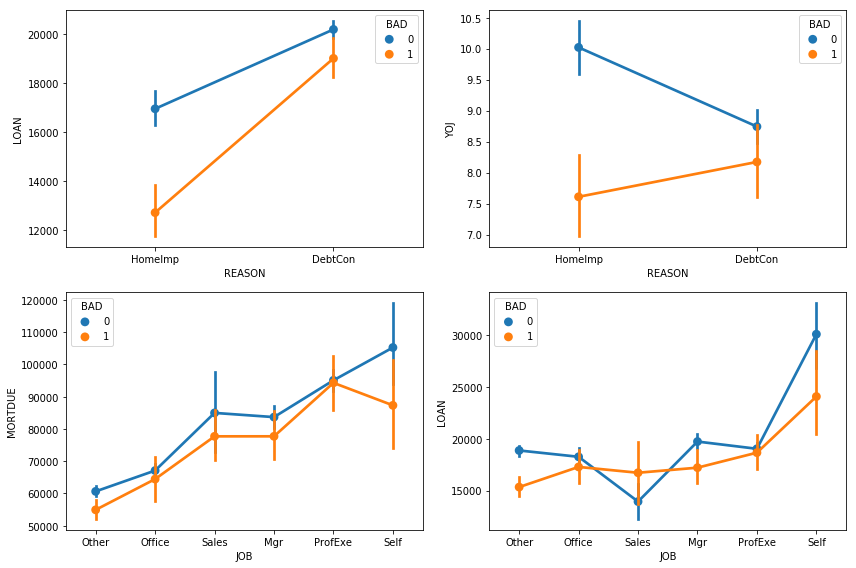

In [59]:
plt.figure(figsize=(12,8))

plt.subplot(221)
sns.pointplot(x="REASON", y="LOAN", hue="BAD", data=df)

plt.subplot(222)
sns.pointplot(x="REASON", y="YOJ", hue="BAD", data=df)

plt.subplot(223)
sns.pointplot(x="JOB", y="MORTDUE", hue="BAD", data=df)

plt.subplot(224)
sns.pointplot(x="JOB", y="LOAN", hue="BAD", data=df)

#plt.subplot(225)
#sns.pointplot(x="JOB", y="VALUE", hue="BAD", data=df)

plt.tight_layout()

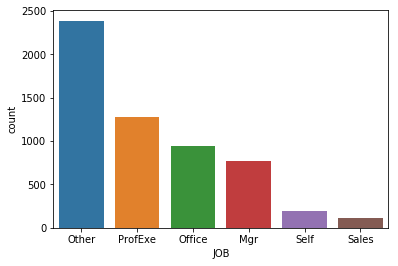

In [60]:
#sns.set()
order=["Other","ProfExe","Office","Mgr","Self","Sales"]

sns.countplot(x="JOB", order=order, data=df)

### Initial Modeling

In [61]:
import scipy as sci
import sklearn as sl

First, we will fit a simple model with all of the explanatory variables to get a idea of predictive baseline performance.

In [62]:
# Create dummy variables and drop the baseline dummy
df_dummies = pd.get_dummies(df_NoNaN,columns=['REASON', 'JOB'], drop_first=True)

In [63]:
# Check to ensure dummy variables were created.False
df_dummies.head()

,BAD,LOAN,MORTDUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_HomeImp,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
5,1,1700,30548.0,9.0,0.0,0.0,101.466002,1.0,8.0,37.113614,1,0,1,0,0,0
7,1,1800,28502.0,11.0,0.0,0.0,88.766030,0.0,8.0,36.884894,1,0,1,0,0,0
19,0,2300,102370.0,2.0,0.0,0.0,90.992533,0.0,13.0,31.588503,1,1,0,0,0,0
25,1,2400,34863.0,12.0,0.0,0.0,70.491080,1.0,21.0,38.263601,1,0,0,0,0,0
26,0,2400,98449.0,4.0,0.0,0.0,93.811775,0.0,13.0,29.681827,1,1,0,0,0,0


In [64]:
# Scale continuous variables except response and dummy variables. <br> 
# Interpretation of coefficients may be difficult as a result

#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

# scaler = preprocessing.StandardScaler()
scaler = MinMaxScaler()

# Standardize everything EXCEPT the indicatior variables
df_dummies[['LOAN','MORTDUE','YOJ',
            'DEROG','DELINQ',
            'CLAGE','NINQ',
            'CLNO','DEBTINC']] = scaler.fit_transform(df_dummies[['LOAN','MORTDUE','YOJ',
                                                                  'DEROG','DELINQ',
                                                                  'CLAGE','NINQ',
                                                                  'CLNO','DEBTINC']])

In [65]:
# Ensure varaibles have been scalled between 0 and 1
df_dummies.head()

,BAD,LOAN,MORTDUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_HomeImp,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
5,1,0.000000,0.064595,0.219512,0.0,0.0,0.086474,0.076923,0.125000,0.253054,1,0,1,0,0,0
7,1,0.001134,0.059406,0.268293,0.0,0.0,0.075598,0.000000,0.125000,0.251458,1,0,1,0,0,0
19,0,0.006803,0.246729,0.048780,0.0,0.0,0.077505,0.000000,0.203125,0.214511,1,1,0,0,0,0
25,1,0.007937,0.075537,0.292683,0.0,0.0,0.059948,0.076923,0.328125,0.261076,1,0,0,0,0,0
26,0,0.007937,0.236785,0.097561,0.0,0.0,0.079919,0.000000,0.203125,0.201211,1,1,0,0,0,0


In [66]:
#Create target and feature variables
features = ['LOAN','MORTDUE','YOJ','DEROG','DELINQ','CLAGE','NINQ','CLNO','DEBTINC',
           'REASON_HomeImp', 'JOB_Office', 'JOB_Other', 'JOB_ProfExe', 'JOB_Sales', 'JOB_Self']

#Create feature
X = df_dummies[features] 

#Create Target
y = df_dummies['BAD']

In [67]:
from sklearn.model_selection import train_test_split

# 75/25 training/test split. random_state equivalent to set.seed in R
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7)

### LASSO Regression Model (LRM)
using Scikit Learn Library

In [68]:
from sklearn.linear_model import LogisticRegression

#Optimizing logistic function with L1 penalty (LASSO)
logreg = LogisticRegression(penalty='l1', solver='liblinear')
lrf = logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

It looks like the Lasso Regression Model worked as expected. Two of the variable coefficients were shrunk toward zero, essentially removing them from the model.

In [69]:
# Still need to figure out how to print summary table. Sklearn doesn't allow.
print(lrf.coef_)

#Labels for coefficient
print("features = ['LOAN','MORTDUE','YOJ','DEROG','DELINQ','CLAGE','NINQ','CLNO','DEBTINC', 'REASON_HomeImp', 'JOB_Office', 'JOB_Other', 'JOB_ProfExe', 'JOB_Sales', 'JOB_Self']")

[[-0.93101946  0.         -0.19356227  6.26505316  6.33421611 -5.9379559
   1.02863827 -0.34164104 10.91971081 -0.05152998 -0.6053611   0.
  -0.17419973  0.93145371  0.39305757]]
features = ['LOAN','MORTDUE','YOJ','DEROG','DELINQ','CLAGE','NINQ','CLNO','DEBTINC', 'REASON_HomeImp', 'JOB_Office', 'JOB_Other', 'JOB_ProfExe', 'JOB_Sales', 'JOB_Self']


### LRM Model Evaluation

In [76]:
# Define confusion matrix for LRM
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test,y_pred)

In [77]:
# Define confusion matrix for LRM
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test,y_pred)

In [78]:
confusion_matrix(y_test,y_pred)

array([[615,   3],
       [ 43,  12]], dtype=int64)

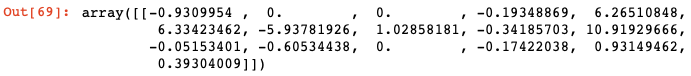

In [79]:
from sklearn.metrics import accuracy_score

LRMscore = accuracy_score(y_test,y_pred) 

round(LRMscore*100,2)

93.16

In [82]:
# Define confusion matrix for LRM
from sklearn.metrics import confusion_matrix

# Define plot. Given by sklearn website
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    plt.figure(figsize=(12,8))


    plot_confusion_matrix(cm           = cnf_matrix, 
                      normalize    = False,
                      target_names = ['Paid', 'Default'],
                      title        = "Confusion Matrix")

    plot_confusion_matrix(cm           = cnf_matrix, 
                      normalize    = True,
                      target_names = ['Paid', 'Default'],
                      title        = "Confusion Matrix, Normalized")

    plt.tight_layout()

In [83]:
# Precision = 
# Recall = how many of the observed cases were correctly predicted?
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.93      1.00      0.96       618
           1       0.80      0.22      0.34        55

   micro avg       0.93      0.93      0.93       673
   macro avg       0.87      0.61      0.65       673
weighted avg       0.92      0.93      0.91       673



AUC: 0.803


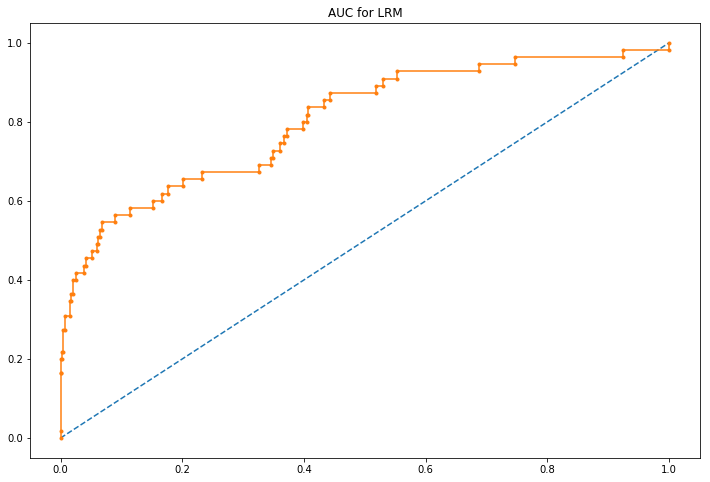

In [84]:
#LRM Model Lack of Fit with AUC

import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

plt.figure(figsize=(12,8))
plt.title("AUC for LRM")

# predict probabilities
probs = logreg.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()



### Elastic Net  Regression
##THIS IS NOT COMPLETE
from Sklearn Library
#ref https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html
#ref https://www.oreilly.com/library/view/hands-on-machine-learning/9781491962282/ch04.html

In [85]:
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression

#Optimizing logistic function with ElasticNet L1 ratio
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
ENRf = elastic_net.fit(X_train, y_train)
ENRy_pred = elastic_net.predict(X_test)


In [86]:
# Still need to figure out how to print summary table. Sklearn doesn't allow.
print(ENRf.coef_)

#Labels for coefficient
print("features = ['LOAN','MORTDUE','YOJ','DEROG','DELINQ','CLAGE','NINQ','CLNO','DEBTINC', 'REASON_HomeImp', 'JOB_Office', 'JOB_Other', 'JOB_ProfExe', 'JOB_Sales', 'JOB_Self']")

[-0. -0. -0.  0.  0. -0.  0.  0.  0. -0. -0.  0. -0.  0.  0.]
features = ['LOAN','MORTDUE','YOJ','DEROG','DELINQ','CLAGE','NINQ','CLNO','DEBTINC', 'REASON_HomeImp', 'JOB_Office', 'JOB_Other', 'JOB_ProfExe', 'JOB_Sales', 'JOB_Self']


### ENR Model Evaluation

In [87]:
# Define confusion matrix for LRM
from sklearn.metrics import confusion_matrix

ENRcnf_matrix = confusion_matrix(y_test,ENRy_pred)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [88]:
# Define confusion matrix for LRM
from sklearn.metrics import confusion_matrix

ENRcnf_matrix = confusion_matrix(y_test,ENRy_pred)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [89]:
from sklearn.metrics import accuracy_score

ENRscore = accuracy_score(y_test,round(score*100,2)) 

round(ENRscore*100,2)

NameError: name 'score' is not defined

In [90]:
plt.figure(figsize=(12,8))


plot_confusion_matrix(cm           = ENRcnf_matrix, 
                      normalize    = False,
                      target_names = ['Paid', 'Default'],
                      title        = "Confusion Matrix")

plot_confusion_matrix(cm           = ENRcnf_matrix, 
                      normalize    = True,
                      target_names = ['Paid', 'Default'],
                      title        = "Confusion Matrix, Normalized")

plt.tight_layout()

NameError: name 'ENRcnf_matrix' is not defined

<Figure size 864x576 with 0 Axes>

In [91]:
# Precision = 
# Recall = how many of the observed cases were correctly predicted?
from sklearn.metrics import classification_report

print(classification_report(y_test, ENRy_pred))


ValueError: Classification metrics can't handle a mix of binary and continuous targets

AttributeError: 'ElasticNet' object has no attribute 'predict_proba'

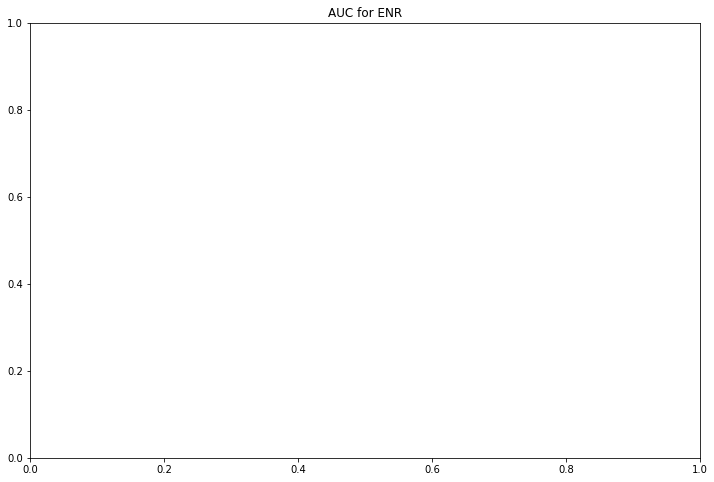

In [92]:
#LRM Model Lack of Fit with AUC

import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

plt.figure(figsize=(12,8))
plt.title("AUC for ENR")

# predict probabilities
probs = elastic_net.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()


In [93]:
#df['PROP_EQUITY'] = df['VALUE']-df.['MORTDUE'] # Created feature to get a sense of equity value for home